# Resnet with Label Smooting and Confidence Thresholding

## Install roblow and download dataset

In [ ]:
!pip install roboflow
!pip install pillow_heif==0.15.0 # Install a compatible version
from roboflow import Roboflow
rf = Roboflow(api_key="TS1niacLXvvWTierCKCT")
project = rf.workspace("insectai").project("new_images-kmnhv")
version = project.version(1)
dataset = version.download("yolov8")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.9/86.9 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 77.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 79.7 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.12.0.88
    Uninstalling opencv-python-headless-4.12.0.88:
      Successfully uninstalled opencv-python-headless-4.12.0.88
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 41.5 MB/s eta 0:00:00
  Attempting uninstall: pillow_heif
    Found existing installation: pillow_heif 1.0.0
    Uninstalling pillow_heif-1.0.0:
      Successfully uninstalled pillow_heif-1.0.0
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to New_images-1 in yolov8:: 100%|██████████| 66/66 [00:00<00:00, 1170.39it/s]


## Extract bounding boxes and save cropped images with augmentation.
### Change target counts to vary augmentaion

In [ ]:
import cv2
import numpy as np
import os
from glob import glob
from tqdm import tqdm
from collections import Counter
import random
import shutil
from sklearn.model_selection import train_test_split

# === CONFIGURATION ===
dataset_root = dataset.location
label_dirs = [os.path.join(dataset_root, split, "labels") for split in ["train", "valid"]]
image_dirs = [os.path.join(dataset_root, split, "images") for split in ["train", "valid"]]
output_dir = "balanced_dataset"
os.makedirs(output_dir, exist_ok=True)

# Custom augmentation targets per class
target_counts = {
    0: 400,   # Caddisfly
    2: 400,   # Mayfly
    4: 400,   # Stonefly
    5: 400,
}

test_ratio = 0.15
val_ratio = 0.15

# === UTILITIES ===
def yolo_to_xyxy(bbox, img_w, img_h):
    x_c, y_c, w, h = bbox
    x1 = int((x_c - w / 2) * img_w)
    y1 = int((y_c - h / 2) * img_h)
    x2 = int((x_c + w / 2) * img_w)
    y2 = int((y_c + h / 2) * img_h)
    return x1, y1, x2, y2

def apply_augmentations(crop):
    angle = random.choice([0, 90, 180, 270]) + random.randint(0, 15)
    crop = np.rot90(crop, k=angle // 90)
    crop = cv2.GaussianBlur(crop, (5, 5), 0)
    noise = np.random.normal(0, 10, crop.shape).astype(np.uint8)
    crop = cv2.add(crop, noise)
    return crop

# === CROP AND AUGMENT ===
class_counter = Counter()
pre_aug_counter = Counter()
image_paths_by_class = {i: [] for i in range(6)}

for label_dir, image_dir in zip(label_dirs, image_dirs):
    for label_file in tqdm(glob(f"{label_dir}/*.txt")):
        image_file = label_file.replace(label_dir, image_dir).replace('.txt', '.jpg')
        img = cv2.imread(image_file)
        if img is None:
            continue
        h, w = img.shape[:2]

        with open(label_file, "r") as f:
            lines = f.readlines()

        for idx, line in enumerate(lines):
            parts = line.strip().split()
            class_id = int(parts[0])
            bbox = list(map(float, parts[1:]))
            x1, y1, x2, y2 = yolo_to_xyxy(bbox, w, h)
            crop = img[y1:y2, x1:x2]
            if crop.size == 0:
                continue

            class_folder = os.path.join(output_dir, str(class_id))
            os.makedirs(class_folder, exist_ok=True)

            filename = os.path.basename(image_file).replace('.jpg', f'_{idx}.jpg')
            save_path = os.path.join(class_folder, filename)
            cv2.imwrite(save_path, crop)
            image_paths_by_class[class_id].append(save_path)
            class_counter[class_id] += 1
            pre_aug_counter[class_id] += 1

            # Augment only if class is in target_counts and under target
            if class_id in target_counts:
                while class_counter[class_id] < target_counts[class_id]:
                    aug_crop = apply_augmentations(crop)
                    aug_filename = filename.replace('.jpg', f'_aug{class_counter[class_id]}.jpg')
                    aug_path = os.path.join(class_folder, aug_filename)
                    cv2.imwrite(aug_path, aug_crop)
                    image_paths_by_class[class_id].append(aug_path)
                    class_counter[class_id] += 1

# === PRINT COUNTS ===
print("\n📊 Pre-augmentation class distribution:")
for class_id in sorted(pre_aug_counter):
    print(f"Class {class_id}: {pre_aug_counter[class_id]} original crops")

print("\n✅ Final class distribution after augmentation:")
for class_id in sorted(class_counter):
    print(f"Class {class_id}: {class_counter[class_id]} total samples")

# === SPLIT INTO TRAIN/VAL/TEST ===
final_split_dir = "resnet_split"
for split in ["train", "val", "test"]:
    for class_id in range(6):
        os.makedirs(os.path.join(final_split_dir, split, str(class_id)), exist_ok=True)

for class_id, paths in image_paths_by_class.items():
    train_val, test = train_test_split(paths, test_size=test_ratio, random_state=42)
    train, val = train_test_split(train_val, test_size=val_ratio / (1 - test_ratio), random_state=42)

    for split_name, split_paths in zip(["train", "val", "test"], [train, val, test]):
        for path in split_paths:
            dest = os.path.join(final_split_dir, split_name, str(class_id), os.path.basename(path))
            shutil.copy(path, dest)

print("\n📁 Dataset split into train/val/test and ready for ResNet training.")

100%|██████████| 4/4 [00:00<00:00, 10.95it/s]



📊 Pre-augmentation class distribution:
Class 0: 22 original crops
Class 1: 4216 original crops
Class 2: 11 original crops
Class 3: 437 original crops
Class 4: 19 original crops
Class 5: 174 original crops

✅ Final class distribution after augmentation:
Class 0: 421 total samples
Class 1: 4216 total samples
Class 2: 410 total samples
Class 3: 437 total samples
Class 4: 418 total samples
Class 5: 573 total samples

📁 Dataset split into train/val/test and ready for ResNet training.


## Make tensorflow dataset

*   Loadded images
*   Normalisation
*   One hot Encoding




In [44]:
import tensorflow as tf

# === CONFIGURATION ===
data_dir = 'resnet_split'
image_size = (224, 224)
batch_size = 32
seed = 42

# === LOAD DATASETS ===
train_dataset = tf.keras.utils.image_dataset_from_directory(
    directory=os.path.join(data_dir, 'train'),
    labels='inferred',
    label_mode='int',
    image_size=image_size,
    batch_size=batch_size,
    shuffle=True,
    seed=seed
)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    directory=os.path.join(data_dir, 'val'),
    labels='inferred',
    label_mode='int',
    image_size=image_size,
    batch_size=batch_size,
    shuffle=True,
    seed=seed
)

test_dataset = tf.keras.utils.image_dataset_from_directory(
    directory=os.path.join(data_dir, 'test'),
    labels='inferred',
    label_mode='int',
    image_size=image_size,
    batch_size=batch_size,
    shuffle=False
)

# === NORMALIZATION ===
normalization_layer = tf.keras.layers.Rescaling(1./255)

NUM_CLASSES = 6

def preprocess(x, y):
    x = normalization_layer(x)
    y = tf.one_hot(y, depth=NUM_CLASSES)  # ✅ one-hot encode
    return x, y

train_dataset = train_dataset.map(preprocess)
validation_dataset = validation_dataset.map(preprocess)
test_dataset = test_dataset.map(preprocess)

# === PREFETCHING ===
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)


Found 4527 files belonging to 6 classes.
Found 974 files belonging to 6 classes.
Found 974 files belonging to 6 classes.


## Define Resnet50 model

*   Loss - Categorical Crossentropy with label smoothing applied



In [ ]:
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# === CONFIGURATION ===
MODEL_NAME = 'best_model.keras'
NUM_CLASSES = 6
IMAGE_SHAPE = (224, 224, 3)
LEARNING_RATE = 1e-4
LABEL_SMOOTHING = 0.1

# === CALLBACKS ===
checkpoint_cb = ModelCheckpoint(
    filepath=MODEL_NAME,
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    mode='min',
    verbose=1
)

early_stop_cb = EarlyStopping(
    patience=7,
    monitor='val_loss',
    min_delta=0,
    mode='min',
    restore_best_weights=True,
    verbose=1
)

callbacks = [checkpoint_cb, early_stop_cb]

# === MODEL DEFINITION ===
def build_resnet_model(num_classes=NUM_CLASSES, input_shape=IMAGE_SHAPE):
    base_model = tf.keras.applications.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=input_shape
    )
    base_model.trainable = True

    model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
        loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False, label_smoothing=LABEL_SMOOTHING),
        metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
    )

    return model


In [ ]:
model = build_resnet_model(num_classes=6)
model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,113,798 (91.99 MB)

 Trainable params: 24,060,678 (91.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

Training Block

In [ ]:
model = build_resnet_model(num_classes=6)

history_original = model.fit(train_dataset, validation_data=validation_dataset, epochs=30, callbacks=callbacks)

test_loss, test_acc, test_precision, test_recall = model.evaluate(test_dataset)
print(f"✅ Test accuracy: {test_acc:.4f}")
print(f"✅ Test precision: {test_precision:.4f}")
print(f"✅ Test recall: {test_recall:.4f}")

Epoch 1/30
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step - accuracy: 0.8431 - loss: 0.8339 - precision_1: 0.8951 - recall_1: 0.7794
Epoch 1: val_loss improved from inf to 1.64693, saving model to best_model.keras
142/142 ━━━━━━━━━━━━━━━━━━━━ 142s 553ms/step - accuracy: 0.8433 - loss: 0.8332 - precision_1: 0.8953 - recall_1: 0.7798 - val_accuracy: 0.6499 - val_loss: 1.6469 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 2/30
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step - accuracy: 0.9241 - loss: 0.6075 - precision_1: 0.9408 - recall_1: 0.9023
Epoch 2: val_loss did not improve from 1.64693
142/142 ━━━━━━━━━━━━━━━━━━━━ 44s 308ms/step - accuracy: 0.9241 - loss: 0.6075 - precision_1: 0.9409 - recall_1: 0.9024 - val_accuracy: 0.0678 - val_loss: 2.0454 - val_precision_1: 0.0678 - val_recall_1: 0.0678
Epoch 3/30
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - accuracy: 0.9491 - loss: 0.5475 - precision_1: 0.9626 - recall_1: 0.9327
Epoch 3: val_loss improved from 1.64693 to 1.60586, savi

ValueError: too many values to unpack (expected 2)

In [ ]:
test_loss, test_acc, test_precision, test_recall = model.evaluate(test_dataset)
print(f"✅ Test accuracy: {test_acc:.4f}")
print(f"✅ Test precision: {test_precision:.4f}")
print(f"✅ Test recall: {test_recall:.4f}")

31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step - accuracy: 0.9630 - loss: 0.5145 - precision_1: 0.9724 - recall_1: 0.9607
✅ Test accuracy: 0.9158
✅ Test precision: 0.9335
✅ Test recall: 0.9076


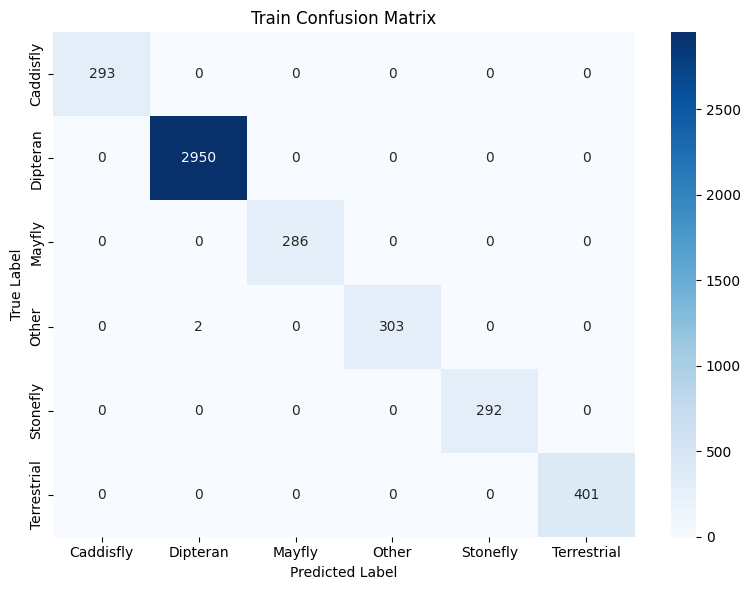

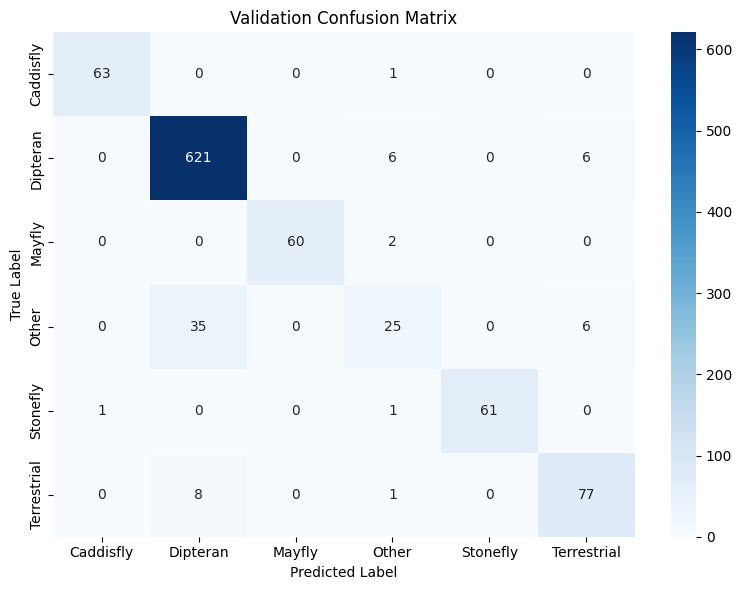

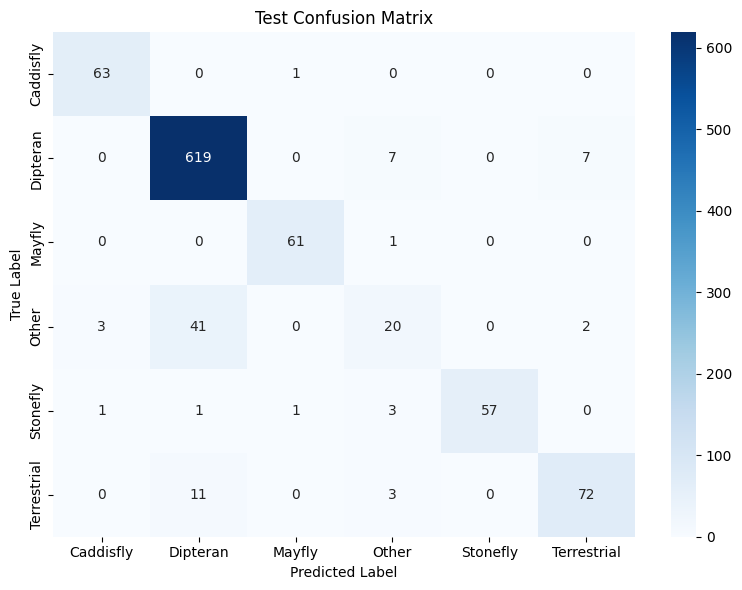

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
class_names = ['Caddisfly', 'Dipteran', 'Mayfly', 'Other', 'Stonefly', 'Terrestrial']
def plot_confusion_matrix(dataset, dataset_name="Dataset"):
    y_true = []
    y_pred = []

    for images, labels in dataset:
        predictions = model.predict(images, verbose=0)

        # Convert one-hot true labels back to class index
        true_classes = np.argmax(labels.numpy(), axis=1)
        pred_classes = np.argmax(predictions, axis=1)

        y_true.extend(true_classes)
        y_pred.extend(pred_classes)

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f"{dataset_name} Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.tight_layout()
    plt.show()



# Plot for validation and test datasets
plot_confusion_matrix(train_dataset, "Train")
plot_confusion_matrix(validation_dataset, "Validation")
plot_confusion_matrix(test_dataset, "Test")

In [4]:
from tensorflow.keras.models import load_model

# Load the .keras model
model = load_model('/content/best_model.keras')

# Check the model summary to confirm it loaded correctly
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 72,235,156 (275.56 MB)

 Trainable params: 24,060,678 (91.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

 Optimizer params: 48,121,358 (183.57 MB)

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
class_names = ['Caddisfly', 'Dipteran', 'Mayfly', 'Other', 'Stonefly', 'Terrestrial']

def plot_confusion_matrix(dataset, dataset_name="Dataset", normalize=False):
    y_true = []
    y_pred = []

    for images, labels in dataset:
        predictions = model.predict(images, verbose=0)

        true_classes = np.argmax(labels.numpy(), axis=1)
        pred_classes = np.argmax(predictions, axis=1)

        y_true.extend(true_classes)
        y_pred.extend(pred_classes)

    norm_option = 'true' if normalize else None
    cm = confusion_matrix(y_true, y_pred, normalize=norm_option)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt=".2f" if normalize else "d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    title = f"{dataset_name} Confusion Matrix"
    if normalize:
        title += " (Normalized)"
    plt.title(title)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.tight_layout()
    plt.show()

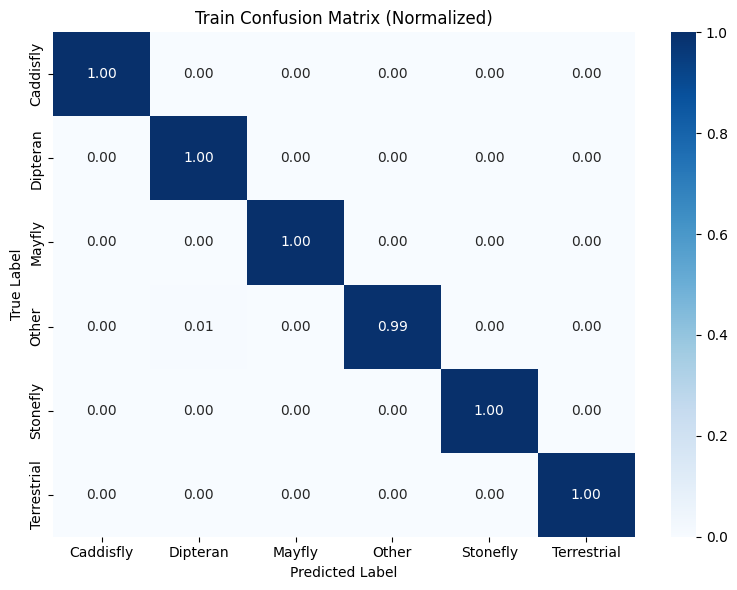

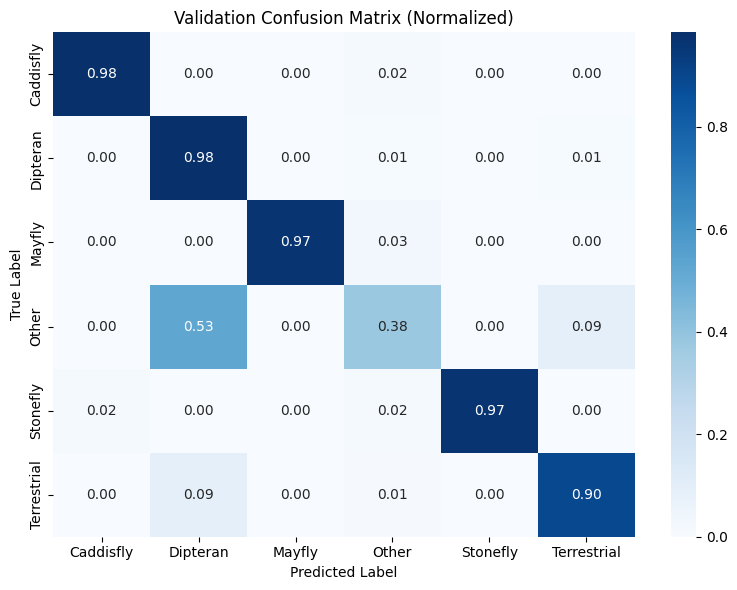

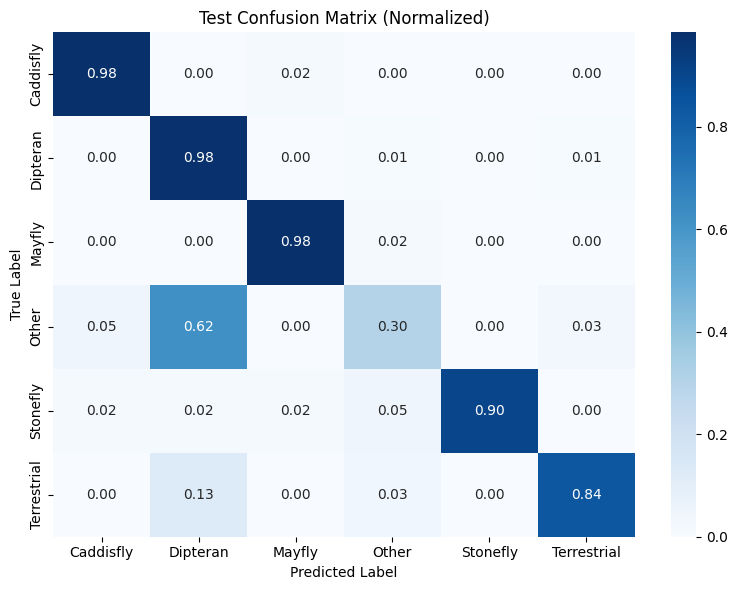

In [8]:
plot_confusion_matrix(train_dataset, "Train", normalize=True)
plot_confusion_matrix(validation_dataset, "Validation", normalize=True)
plot_confusion_matrix(test_dataset, "Test", normalize=True)


In [24]:
import os
import cv2
from glob import glob
from tqdm import tqdm

# === CONFIGURATION ===
image_dir = "/content/New_images-1/test/images"
label_dir = "/content/New_images-1/test/labels"
output_dir = "test_noaug"
image_size = (224, 224)

os.makedirs(output_dir, exist_ok=True)

# === HELPER: YOLO to pixel coordinates ===
def yolo_to_xyxy(bbox, img_w, img_h):
    x_c, y_c, w, h = bbox
    x1 = int((x_c - w / 2) * img_w)
    y1 = int((y_c - h / 2) * img_h)
    x2 = int((x_c + w / 2) * img_w)
    y2 = int((y_c + h / 2) * img_h)
    return x1, y1, x2, y2

# === PROCESS EACH IMAGE ===
for label_path in tqdm(glob(os.path.join(label_dir, "*.txt"))):
    image_path = label_path.replace(label_dir, image_dir).replace(".txt", ".jpg")
    img = cv2.imread(image_path)
    if img is None:
        continue
    h, w = img.shape[:2]

    with open(label_path, "r") as f:
        lines = f.readlines()

    for idx, line in enumerate(lines):
        parts = line.strip().split()
        if len(parts) < 5:
            continue
        class_id = int(parts[0])
        bbox = list(map(float, parts[1:]))
        x1, y1, x2, y2 = yolo_to_xyxy(bbox, w, h)
        crop = img[y1:y2, x1:x2]
        if crop.size == 0 or crop.shape[0] < 10 or crop.shape[1] < 10:
            continue

        # Resize crop
        crop_resized = cv2.resize(crop, image_size)

        # Save to class folder
        class_folder = os.path.join(output_dir, str(class_id))
        os.makedirs(class_folder, exist_ok=True)
        filename = os.path.basename(image_path).replace('.jpg', f'_{idx}.jpg')
        save_path = os.path.join(class_folder, filename)
        cv2.imwrite(save_path, crop_resized)

print("\n✅ Test dataset created at:", output_dir)

100%|██████████| 3/3 [00:00<00:00,  9.49it/s]


✅ Test dataset created at: test_noaug


In [27]:
import os
from collections import Counter

test_dir = "test_noaug"
class_counts = Counter()
class_paths = {"0", "1", "2", "3", "4", "5"}
for class_name in os.listdir(test_dir):
    class_path = os.path.join(test_dir, class_name)
    if os.path.isdir(class_path) and class_name in class_paths:
        num_images = len([f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.png', '.jpeg'))])
        class_counts[class_name] = num_images

# Print results
print("\n📊 Test Set Image Counts:")
for class_id in sorted(class_counts, key=lambda x: int(x)):
    print(f"Class {class_id}: {class_counts[class_id]} images")




📊 Test Set Image Counts:
Class 0: 3 images
Class 1: 461 images
Class 2: 0 images
Class 3: 63 images
Class 4: 2 images
Class 5: 34 images


In [35]:
print(model.metrics_names)

['loss', 'compile_metrics']


In [36]:
from tensorflow.keras.metrics import Accuracy, Precision, Recall

model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=[
        tf.keras.metrics.CategoricalAccuracy(name="accuracy"),
        tf.keras.metrics.Precision(name="precision"),
        tf.keras.metrics.Recall(name="recall")
    ]
)


In [37]:
import tensorflow as tf

# === CONFIGURATION ===
test_dir = "test_noaug"
image_size = (224, 224)
batch_size = 32

# === LOAD TEST DATASET ===
test_no_aug_dataset = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode='int',
    image_size=image_size,
    batch_size=batch_size,
    shuffle=False
)

# === NORMALIZATION & PREFETCHING ===
normalization_layer = tf.keras.layers.Rescaling(1./255)

NUM_CLASSES = 6

def preprocess(x, y):
    x = normalization_layer(x)
    y = tf.cast(y, tf.int32)
    y = tf.one_hot(y, depth=NUM_CLASSES)  # ✅ one-hot encode
    return x, y

test_no_aug_dataset = test_no_aug_dataset.map(preprocess)

AUTOTUNE = tf.data.AUTOTUNE
test_no_aug_dataset = test_no_aug_dataset.prefetch(buffer_size=AUTOTUNE)

# === EVALUATE MODEL ===
test_loss, test_acc, test_precision, test_recall  = model.evaluate(test_no_aug_dataset, verbose=1)
print(f"✅ Test accuracy: {test_acc:.4f}")
print(f"✅ Test precision: {test_precision:.4f}")
print(f"✅ Test recall: {test_recall:.4f}")


Found 563 files belonging to 6 classes.
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 276ms/step - accuracy: 0.8627 - loss: 0.4426 - precision: 0.9033 - recall: 0.8506
✅ Test accuracy: 0.8188
✅ Test precision: 0.8552
✅ Test recall: 0.7869


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


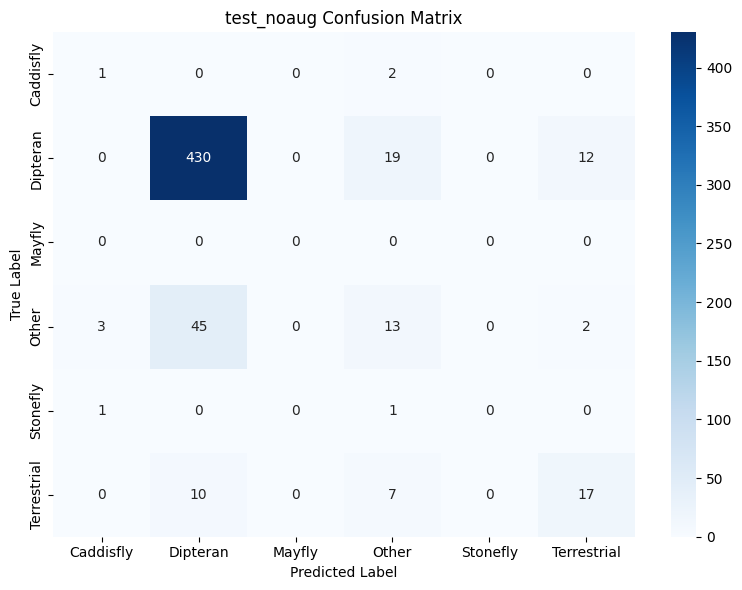

In [40]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# === Get true labels and predictions ===
y_true = []
y_pred = []

for x_batch, y_batch in test_no_aug_dataset:
    preds = model.predict(x_batch)
    y_true.extend(np.argmax(y_batch.numpy(), axis=1))  # convert one-hot to class index
    y_pred.extend(np.argmax(preds, axis=1))            # highest prob class

# === Define class names ===
class_names = ['Caddisfly', 'Dipteran', 'Mayfly', 'Other', 'Stonefly', 'Terrestrial']
num_classes = len(class_names)

# === Confusion matrix with fixed label order ===
cm = confusion_matrix(y_true, y_pred, labels=list(range(num_classes)))

# === Plot ===
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('test_noaug Confusion Matrix')
plt.tight_layout()
plt.show()


In [47]:
import pandas as pd

# Store results
all_results = []

for x_batch, y_batch in test_dataset:
    preds = model.predict(x_batch)
    true_labels = np.argmax(y_batch.numpy(), axis=1)
    pred_labels = np.argmax(preds, axis=1)
    confidences = np.max(preds, axis=1)

    for true, pred, conf in zip(true_labels, pred_labels, confidences):
        is_correct = int(true == pred)
        all_results.append({
            'true_label': true,
            'pred_label': pred,
            'confidence': conf,
            'is_correct': is_correct
        })

df = pd.DataFrame(all_results)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

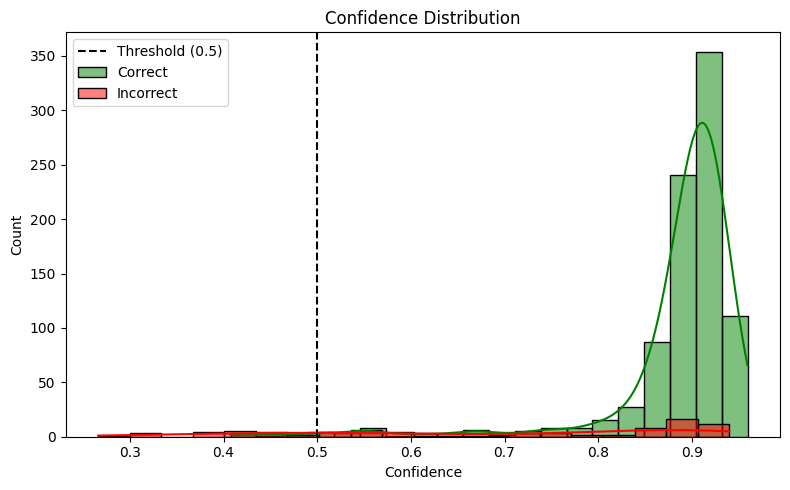

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.histplot(df[df.is_correct == 1]['confidence'], bins=20, color='green', label='Correct', kde=True)
sns.histplot(df[df.is_correct == 0]['confidence'], bins=20, color='red', label='Incorrect', kde=True)
plt.axvline(0.5, color='black', linestyle='--', label='Threshold (0.5)')
plt.xlabel('Confidence')
plt.ylabel('Count')
plt.title('Confidence Distribution')
plt.legend()
plt.tight_layout()
plt.show()


In [51]:
dipteran_vs_other_confusion = []

for x_batch, y_batch in test_dataset:
    preds = model.predict(x_batch)
    true_labels = np.argmax(y_batch.numpy(), axis=1)
    pred_labels = np.argmax(preds, axis=1)
    confidences = np.max(preds, axis=1)

    for img, true, pred, conf in zip(x_batch, true_labels, pred_labels, confidences):
        if (true == 1 and pred == 1) or (true == 3 and pred == 1):
            dipteran_vs_other_confusion.append({
                'image': img,
                'true_label': true,
                'pred_label': pred,
                'confidence': conf
            })


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

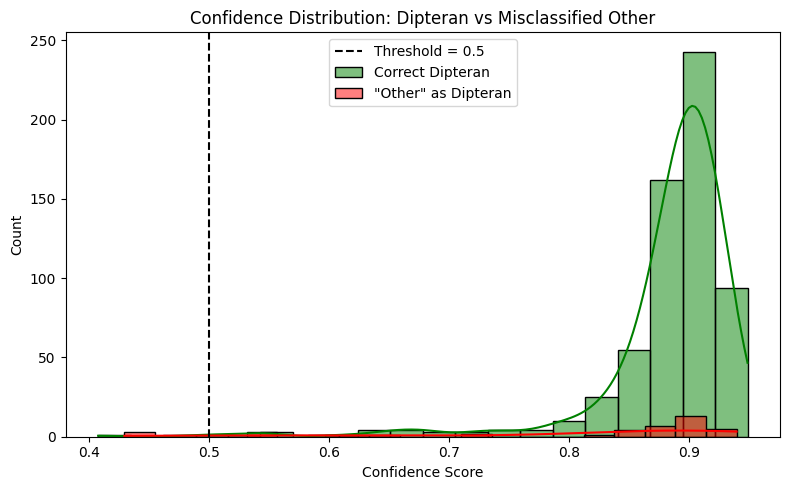

In [52]:
import seaborn as sns
import matplotlib.pyplot as plt

# Extract confidence values
correct_dipteran_conf = [d['confidence'] for d in dipteran_vs_other_confusion if d['true_label'] == 1 and d['pred_label'] == 1]
other_as_dipteran_conf = [d['confidence'] for d in dipteran_vs_other_confusion if d['true_label'] == 3 and d['pred_label'] == 1]

# Plot histogram
plt.figure(figsize=(8, 5))
sns.histplot(correct_dipteran_conf, color='green', label='Correct Dipteran', bins=20, kde=True)
sns.histplot(other_as_dipteran_conf, color='red', label='"Other" as Dipteran', bins=20, kde=True)
plt.axvline(0.5, linestyle='--', color='black', label='Threshold = 0.5')
plt.xlabel('Confidence Score')
plt.ylabel('Count')
plt.title('Confidence Distribution: Dipteran vs Misclassified Other')
plt.legend()
plt.tight_layout()
plt.show()


In [58]:
dipteran_vs_other_confusion_test_no_aug = []

for x_batch, y_batch in test_no_aug_dataset:
    preds = model.predict(x_batch)
    true_labels = np.argmax(y_batch.numpy(), axis=1)
    pred_labels = np.argmax(preds, axis=1)
    confidences = np.max(preds, axis=1)

    for img, true, pred, conf in zip(x_batch, true_labels, pred_labels, confidences):
        if (true == 1 and pred == 1) or (true == 3 and pred == 1):
            dipteran_vs_other_confusion_test_no_aug.append({
                'image': img,
                'true_label': true,
                'pred_label': pred,
                'confidence': conf
            })


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


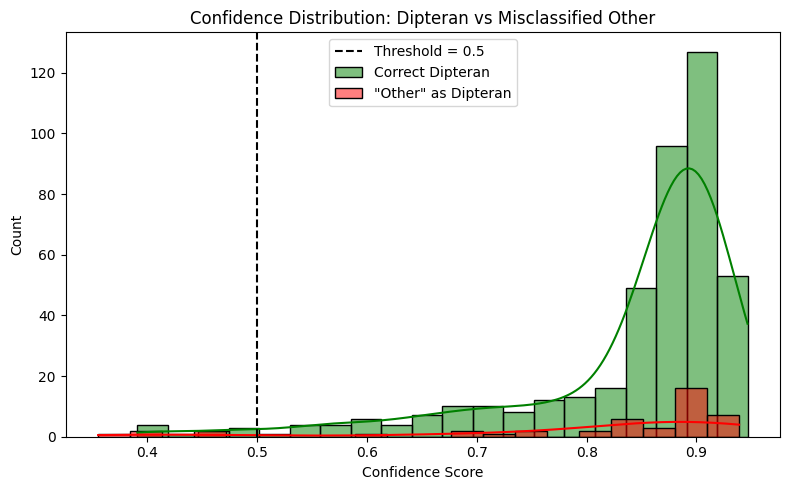

In [59]:
import seaborn as sns
import matplotlib.pyplot as plt

# Extract confidence values
correct_dipteran_conf = [d['confidence'] for d in dipteran_vs_other_confusion_test_no_aug if d['true_label'] == 1 and d['pred_label'] == 1]
other_as_dipteran_conf = [d['confidence'] for d in dipteran_vs_other_confusion_test_no_aug if d['true_label'] == 3 and d['pred_label'] == 1]

# Plot histogram
plt.figure(figsize=(8, 5))
sns.histplot(correct_dipteran_conf, color='green', label='Correct Dipteran', bins=20, kde=True)
sns.histplot(other_as_dipteran_conf, color='red', label='"Other" as Dipteran', bins=20, kde=True)
plt.axvline(0.5, linestyle='--', color='black', label='Threshold = 0.5')
plt.xlabel('Confidence Score')
plt.ylabel('Count')
plt.title('Confidence Distribution: Dipteran vs Misclassified Other')
plt.legend()
plt.tight_layout()
plt.show()

Evaluate test datset perforance at different thresholds

=== Performance at 0.75 Threshold ===
              precision    recall  f1-score   support

   Caddisfly       1.00      0.94      0.97        64
    Dipteran       0.94      0.92      0.93       633
      Mayfly       1.00      0.97      0.98        62
       Other       0.32      0.55      0.40        66
    Stonefly       1.00      0.89      0.94        63
 Terrestrial       0.98      0.76      0.86        86

    accuracy                           0.88       974
   macro avg       0.87      0.84      0.85       974
weighted avg       0.91      0.88      0.89       974



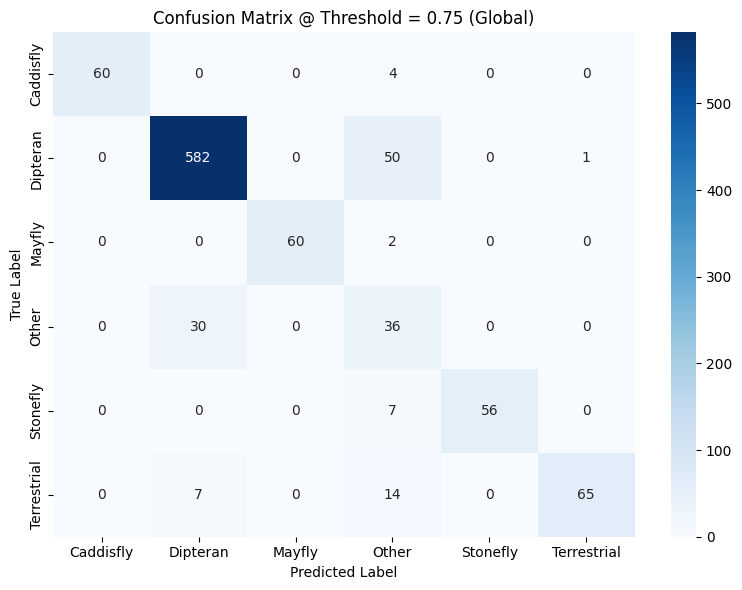

In [66]:
threshold = 0.80
OTHER_IDX = 3  # Update if "Other" is a different index

adjusted_preds_075 = [
    OTHER_IDX if row['confidence'] < threshold else row['pred_label']
    for row in all_results
]
y_true_labels = [row['true_label'] for row in all_results]

from sklearn.metrics import classification_report, confusion_matrix

# Print classification metrics
print("=== Performance at 0.75 Threshold ===")
print(classification_report(y_true_labels, adjusted_preds_075, target_names=class_names, zero_division=0))

# Plot confusion matrix
cm = confusion_matrix(y_true_labels, adjusted_preds_075, labels=list(range(num_classes)))

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix @ Threshold = 0.75 (Global)')
plt.tight_layout()
plt.show()


In [68]:
import pandas as pd

# Store results
all_results_no_aug = []

for x_batch, y_batch in test_no_aug_dataset:
    preds = model.predict(x_batch)
    true_labels = np.argmax(y_batch.numpy(), axis=1)
    pred_labels = np.argmax(preds, axis=1)
    confidences = np.max(preds, axis=1)

    for true, pred, conf in zip(true_labels, pred_labels, confidences):
        is_correct = int(true == pred)
        all_results_no_aug.append({
            'true_label': true,
            'pred_label': pred,
            'confidence': conf,
            'is_correct': is_correct
        })

df_no_aug = pd.DataFrame(all_results_no_aug)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


=== Performance at 0.75 Threshold ===
              precision    recall  f1-score   support

   Caddisfly       0.20      0.33      0.25         3
    Dipteran       0.90      0.91      0.91       461
      Mayfly       0.00      0.00      0.00         0
       Other       0.23      0.29      0.26        63
    Stonefly       0.00      0.00      0.00         2
 Terrestrial       0.62      0.29      0.40        34

    accuracy                           0.80       563
   macro avg       0.33      0.30      0.30       563
weighted avg       0.80      0.80      0.80       563



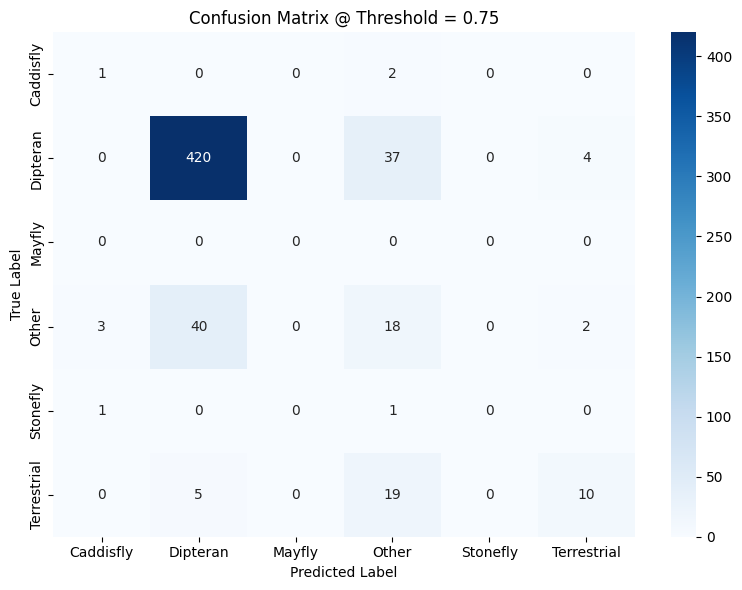

In [76]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# === Define constants ===
threshold = 0.5
OTHER_IDX = 3  # "Other" class index — adjust if needed
class_names = ['Caddisfly', 'Dipteran', 'Mayfly', 'Other', 'Stonefly', 'Terrestrial']
num_classes = len(class_names)

# === Apply threshold to predictions ===
adjusted_preds_075 = [
    OTHER_IDX if row['confidence'] < threshold else row['pred_label']
    for row in all_results_no_aug
]
y_true_labels_no_aug = [row['true_label'] for row in all_results_no_aug]

# === Classification report with full class list ===
print("=== Performance at 0.75 Threshold ===")
print(classification_report(
    y_true_labels_no_aug,
    adjusted_preds_075,
    labels=list(range(num_classes)),
    target_names=class_names,
    zero_division=0
))

# === Confusion matrix ===
cm = confusion_matrix(
    y_true_labels_no_aug,
    adjusted_preds_075,
    labels=list(range(num_classes))
)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix @ Threshold = 0.75')
plt.tight_layout()
plt.show()


=== Performance with Class-Specific Thresholds ===
              precision    recall  f1-score   support

   Caddisfly       1.00      0.98      0.99        64
    Dipteran       0.94      0.94      0.94       633
      Mayfly       0.98      0.98      0.98        62
       Other       0.39      0.52      0.44        66
    Stonefly       1.00      0.89      0.94        63
 Terrestrial       0.93      0.81      0.87        86

    accuracy                           0.90       974
   macro avg       0.87      0.85      0.86       974
weighted avg       0.91      0.90      0.91       974



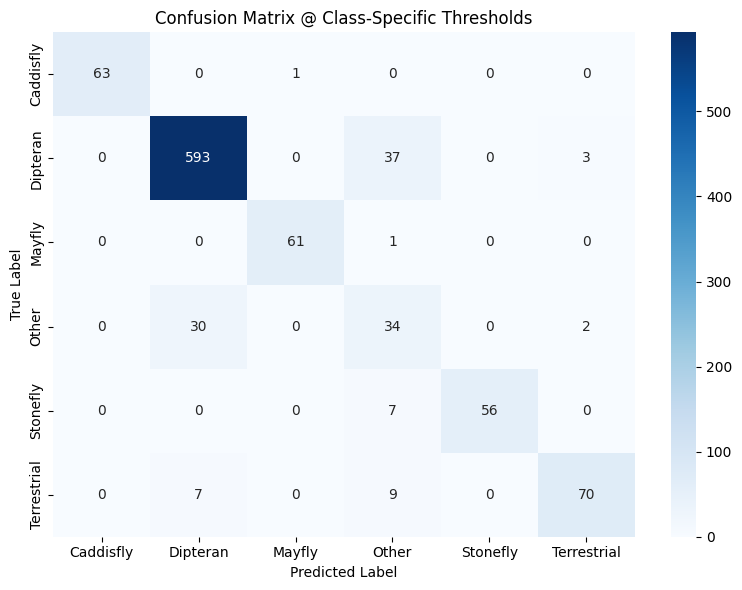

In [85]:
from sklearn.metrics import classification_report, confusion_matrix

# === Set thresholds per predicted class ===
class_thresholds = {
    0: 0.5,  # Caddisfly
    1: 0.75, # Dipteran (stricter)
    2: 0.5,  # Mayfly
    3: 0.0,  # Other (used only when rerouting)
    4: 0.5,  # Stonefly
    5: 0.5   # Terrestrial
}
OTHER_IDX = 3
num_classes = len(class_names)

# === Apply per-class thresholding ===
adjusted_preds_class_specific = []
for row in all_results:
    pred = row['pred_label']
    conf = row['confidence']
    threshold = class_thresholds.get(pred, 0.5)  # default to 0.5 if missing
    adjusted_pred = pred if conf >= threshold else OTHER_IDX
    adjusted_preds_class_specific.append(adjusted_pred)

# === True labels ===
y_true_labels = [row['true_label'] for row in all_results]

# === Report ===
print("=== Performance with Class-Specific Thresholds ===")
print(classification_report(
    y_true_labels,
    adjusted_preds_class_specific,
    labels=list(range(num_classes)),
    target_names=class_names,
    zero_division=0
))

# === Confusion Matrix ===
cm = confusion_matrix(
    y_true_labels,
    adjusted_preds_class_specific,
    labels=list(range(num_classes))
)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix @ Class-Specific Thresholds')
plt.tight_layout()
plt.show()


=== Performance with Class-Specific Thresholds ===
              precision    recall  f1-score   support

   Caddisfly       0.20      0.33      0.25         3
    Dipteran       0.91      0.79      0.85       461
      Mayfly       0.00      0.00      0.00         0
       Other       0.17      0.37      0.23        63
    Stonefly       0.00      0.00      0.00         2
 Terrestrial       0.62      0.29      0.40        34

    accuracy                           0.71       563
   macro avg       0.32      0.30      0.29       563
weighted avg       0.80      0.71      0.74       563



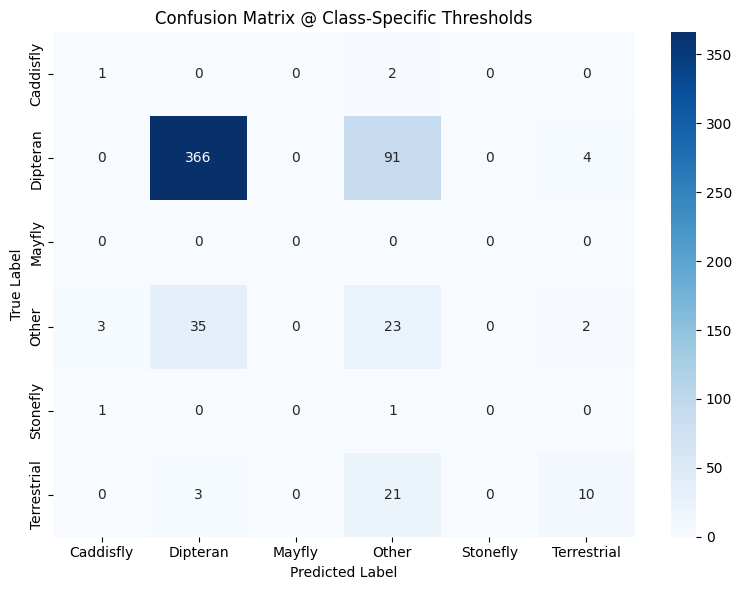

In [84]:
from sklearn.metrics import classification_report, confusion_matrix

# === Set thresholds per predicted class ===
class_thresholds = {
    0: 0.5,  # Caddisfly
    1: 0.75, # Dipteran (stricter)
    2: 0.5,  # Mayfly
    3: 0.0,  # Other (used only when rerouting)
    4: 0.5,  # Stonefly
    5: 0.5   # Terrestrial
}
OTHER_IDX = 3
num_classes = len(class_names)

# === Apply per-class thresholding ===
adjusted_preds_class_specific = []
for row in all_results_no_aug:
    pred = row['pred_label']
    conf = row['confidence']
    threshold = class_thresholds.get(pred, 0.5)  # default to 0.5 if missing
    adjusted_pred = pred if conf >= threshold else OTHER_IDX
    adjusted_preds_class_specific.append(adjusted_pred)

# === True labels ===
y_true_labels = [row['true_label'] for row in all_results_no_aug]

# === Report ===
print("=== Performance with Class-Specific Thresholds ===")
print(classification_report(
    y_true_labels,
    adjusted_preds_class_specific,
    labels=list(range(num_classes)),
    target_names=class_names,
    zero_division=0
))

# === Confusion Matrix ===
cm = confusion_matrix(
    y_true_labels,
    adjusted_preds_class_specific,
    labels=list(range(num_classes))
)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix @ Class-Specific Thresholds')
plt.tight_layout()
plt.show()